# Interpreting Machine Learning Models

## Extracting Human-Understandable Insights from any Machine Learning Model

In his book [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/), Christoph Molnar beautifully encapsulates the essence of ML interpretability through the following example: Imagine that you are a Data Scientist and in your free time you try to predict where your friends will go for their vacation this summer, based on their available Facebook and Twitter data. Now, if the predictions turn out to be accurate, your friends will be impressed. However, if the predictions turn out to be wrong, it would still bring no harm to anyone except to your reputation of being a “Data Scientist.” Now let’s say it wasn’t a fun project and there were investments involved in the decision. Say, you wanted to invest in properties where your friends were likely to holiday. What would happen if the model’s predictions went awry? You would lose money and so would your investors.

As long as the model is having no significant impact, it’s interpretability doesn’t matter as much, but when there are implications involved based on a model’s prediction, be it financial or social, the concept of interpretability becomes paramount.

## Interpretable Machine Learning

Interpret means to explain or to present in understandable terms. In the context of ML systems, interpretability is the ability to explain or to present a machine learning model in understandable terms to a human [[Finale Doshi-Velez_](http://arxiv.org/abs/1702.08608)]. When we talk about model interpretability, there are some vital questions which need to be addressed:

-   How do we extract important insights from the models?
-   What things are to be kept in mind?
-   What features or tools will we need to achieve that?  
      
    

A lot of this has to do with the impact that a model might have in the real world. Models that are merely meant to recommend movies will have far less impact than the ones created to predict the outcome of a drug.

##  Importance of Model Interpretability

Machine learning models are being increasingly used to make decisions that affect people’s lives. With this power comes a responsibility to ensure that the model predictions are fair and not discriminating. It’s not enough to know if a model works, we need to know how it works. 

In a way, we capture the world by collecting raw data and use that data to make further predictions. Essentially, Interpretability is just another layer on the model that helps humans to understand the process.

----------

# Understanding Different Model Interpretability Techniques in Python

So how do we interpret a machine learning model? What kinds of techniques are available and how do they differ from each other? These are some of the questions that will be answered in this section. Although there are a number of techniques, we shall dicuss the following five to explain how different features have a different effect on the prediction of a model.

 - Permutation Importance using ELI5 library
 - Partial Dependence Plots
 - SHAP Values    
 - Advanced Uses of SHAP Values
 - LIME: Locally Interpretable Model-Agnostic Explanations


## Importing Necessary Libraries

Let’s start by importing the necessary libraries.


In [36]:
!pip install -r requirements.txt -q
%matplotlib inline
    
import numpy as np   
import pandas as pd   
import matplotlib.pyplot as plt   
import seaborn as sns  
import lightgbm as lgb
from sklearn import tree
import graphviz
    
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
    
import warnings  
warnings.filterwarnings("ignore")
    

In [37]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(12,8)})

###  Reading in the Dataset

The dataset used is called the **Pima Indians diabetes** dataset and is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The data belong to females of Pima Indian heritage and consists of several medical predictor variables including the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. The dataset used in this notebook belongs to the [Kaggle version and can be accessed here](https://www.kaggle.com/uciml/pima-indians-diabetes-database). The objective of the dataset is to predict where the patient has diabetes or not based on the other diagnostic measurements provided in the dataset.
Let’s read in the data and look at the first few rows



In [38]:
df = pd.read_csv('data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


As can be seen, the dataset consists of various predictor variables like `pregnancies`, `glucose`, `blood pressure`, etc, and one target variable, `outcome`. The `outcome` variable is 1 if the patient has diabetes and 0 for no diabetes. It is a classic binary classification problem. Also, let's check out if there are any missing values in the dataset.


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Theer are no missing values and no string columns in the given dataset.

## 1. Permutation Importance Using ELI5 library

What features does a model think are important? Which features might have a greater impact on the model predictions than others? This concept is called **feature importance** and **Permutation Importance** is a technique used widely for calculating feature importance. It helps us to see when our model produces counterintuitive results, and it helps to show the others when our model is working as we'd hope.

Permutation Importance works for many scikit-learn estimators. The idea is simple: 
* Randomly permutate or shuffle one column in the validation dataset leaving all the other columns intact. 
* A feature is considered &#x201c;important&#x201d; if the model's accuracy drops a lot and causes an increase in error. 
* On the other hand, a feature is considered &#x201c;unimportant&#x201d; if shuffling its values don't affect the model's accuracy.

Permutation Importance helps to provide a high-level overview of the model and thereby aids in understanding which features are more important than the others.

### ELI5 Library

Permutation Importance is calculated using the **ELI5 library**.  [**ELI5**](https://github.com/TeamHG-Memex/eli5) is a Python library which allows to visualize and debug various Machine Learning models using unified API. It has built-in support for several ML frameworks and provides a way to explain black-box models.

Permutation importance is calculated after a model has been fitted. So, let’s train and fit a RandomForestClassifier model on the training data.

### Random Forest Model

Let’s now create a random forest model called `my_model` using the scikit-learn library.

In [40]:
# Creating the target and the features column and splitting the dataset into test and train set._  
  
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]  
  
# splitting the dataset into training and test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

# Training and fitting a Random Forest Model_  
my_model = RandomForestClassifier(n_estimators=100,  
                                  random_state=0).fit(X_train, y_train)

# Making predictions on the test set
predictions = my_model.predict(X_val)  
predictions

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])

We now have our model and our predictions. Let’s now explore the different ways by which we can understand the model and its predictions in a more meaningful way. Here, **val_X** and **val_y** denote the validation sets, respectively.

### Usage: Calculating and Displaying Permutation Importance Using the eli5 Library

In [41]:

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.0885 ± 0.0198,Glucose
0.0229 ± 0.0425,Age
0.0188 ± 0.0106,BloodPressure
0.0031 ± 0.0193,Insulin
0.0021 ± 0.0193,BMI
-0.0021 ± 0.0352,DiabetesPedigreeFunction
-0.0031 ± 0.0193,Pregnancies
-0.0062 ± 0.0078,SkinThickness


### Plotting the distributions

[Text(0,0.5,'Importance'), Text(0.5,1,'Permutation Importance Distributions')]

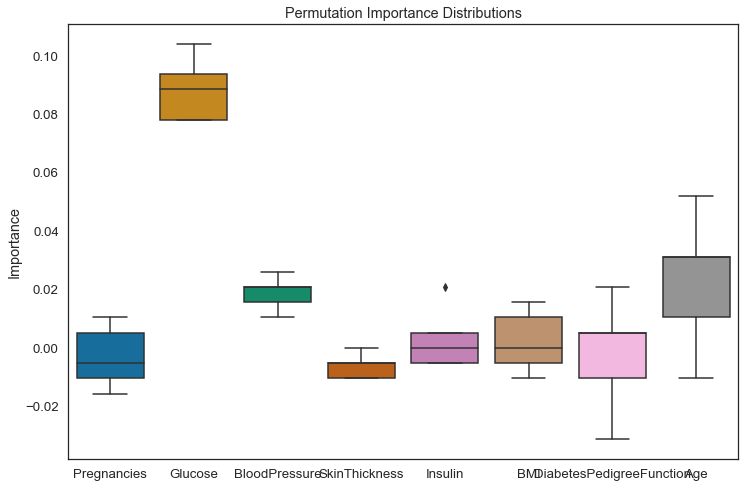

In [42]:
perm_feat_imp_df = pd.DataFrame(data=perm.results_,
                                      columns=X_val.columns.tolist())
(sns.boxplot(data=perm_feat_imp_df)
        .set(title='Permutation Importance Distributions',
             ylabel='Importance'))

### Interpretation

-   The features at the top are most important and at the bottom, the least. For this example, `Glucose level` is the most important feature and decides whether a person will have diabetes, which also makes sense.
-   The number after the  `±` measures how performance varied from one-reshuffling to the next.
-   Some weights are negative. This is because, in those cases, predictions on the shuffled data were found to be more accurate than the real data.
---

## 2. Partial Dependence Plots 

The **partial dependence plot** (short PDP or PD plot) shows the marginal effect that one or two features has on the predicted outcome of a machine learning model ( [_J. H. Friedman 2001_](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)). Whereas permutation importance shows which feature is important, PDPs show how a feature affects predictions. PDP can show the relationship between the target and the selected features via 1D or 2D plots.

### PDPbox
The library to be used for plotting PDPs is called Python [partial dependence plot toolbox](https://pdpbox.readthedocs.io/en/latest/) or simply PDPbox. PDP box supports all scikit learn algorithms.

### Decision Tree Model
PDPs are also calculated after a model has been fit. So, let’s train and fit a machine learning model on the training data.This time we shall use a Decision Tree to showcase the usage of the library.


In [43]:
# training and fitting a Decision Tree

feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                'BMI', 'DiabetesPedigreeFunction', 'Age']
tree_model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)


### Usage: Calculating and Displaying Partial Dependence Plots Using the PDPbox Library

In our dataset there are a lot of features like Glucose, Blood Pressure, Age, etc. We start by considering a single row, say the first one. This row represents a patient who has had six pregnancies, has a glucose level of 148, blood pressure of 72, etc. Next, we will continuously alter the value of a particular variable, for instance, glucose or insulin level, and see how the target variable is affected. Finally, all the values are plotted on a graph and we get a graph of predicted versus actual outcome.

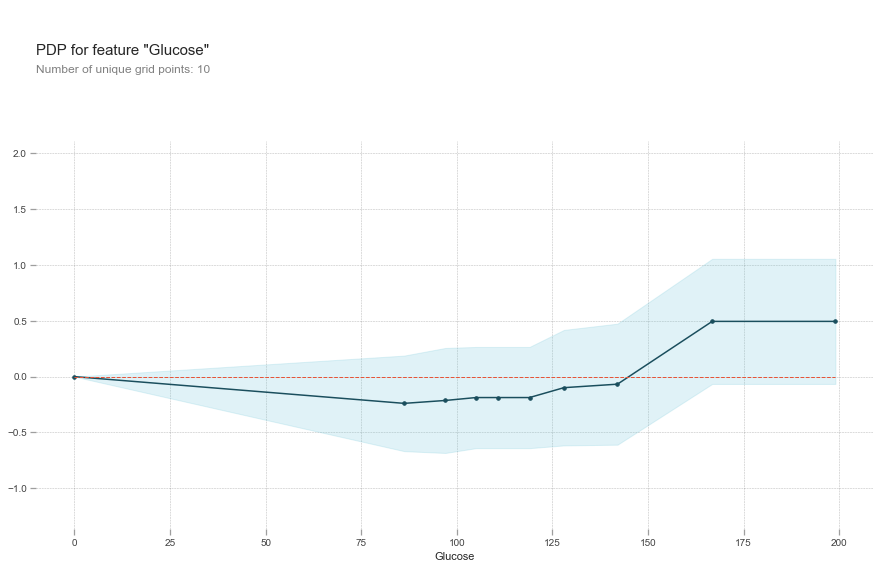

In [45]:
from pdpbox import pdp, info_plots

# PDP plots for Glucose
pdp_glucose = pdp.pdp_isolate(model=tree_model, dataset=X_val, model_features=feature_names, feature='Glucose')

# plot it
pdp.pdp_plot(pdp_glucose, 'Glucose')
plt.show()

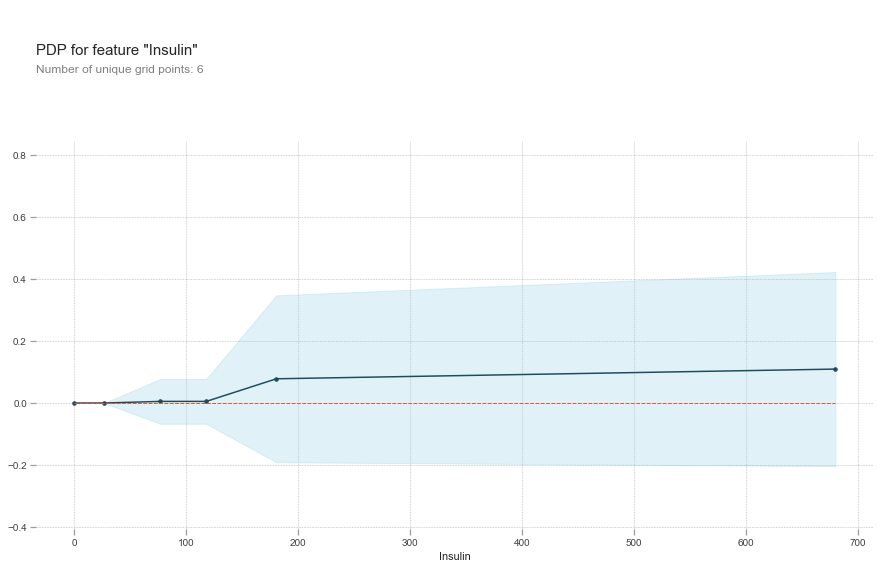

In [46]:
# PDP plots for Insulin
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=X_val, model_features=feature_names, feature='Insulin')

# plot it
pdp.pdp_plot(pdp_goals, 'Insulin')
plt.show()

### Interpretation

-   The Y-axis represents the change in prediction from what would be predicted at the baseline or leftmost value.
-   The blue area denotes the confidence interval.
-   For the ‘Glucose’ graph, we observe that probability of a person having diabetes steeply increases as the glucose level goes beyond 140 and then the probability remains high. Similarly, for the insulin graph, we notice that the probability of a person having diabetes increases when the insulin level goes beyond 100.

We can also visualize the partial dependence of two features at once using **2D Partial Dependence plots**.



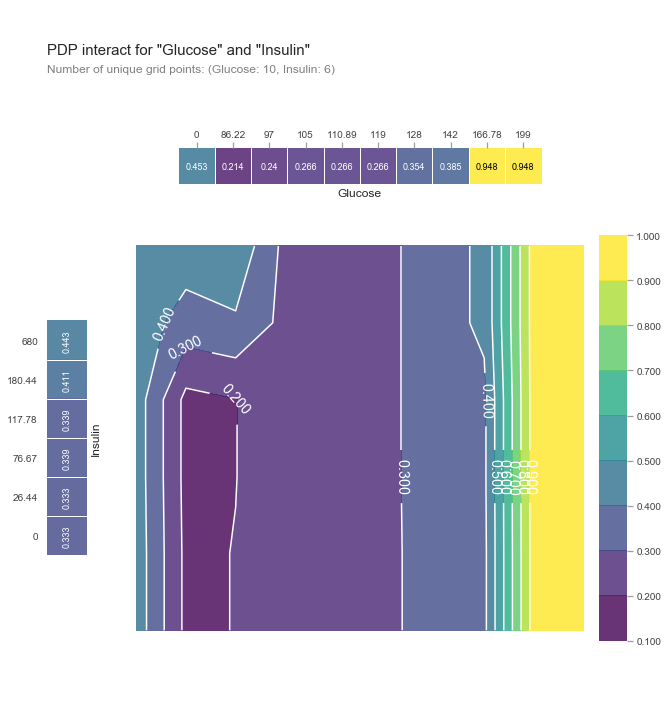

In [47]:
features_to_plot = ['Glucose','Insulin']
inter1  =  pdp.pdp_interact(model=tree_model, dataset=X_val, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour', plot_pdp=True)
plt.show()

This graph above shows the predictions for any combination of Glucose and Insulin levels.

---

## 3. SHAP Values

SHAP, which stands for <strong>SH</strong>apley <strong>A</strong>dditive ex<strong>P</strong>lanation, helps to break down a prediction and shows the impact of each feature on the outcome of the model. It is based on Shapley values, a technique used in game theory to determine how much each player in a collaborative game has contributed to its success.[¹](https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80) Normally, getting the trade-off between accuracy and interpretability just right can be a little tricky but SHAP values can deliver both.

Shap values show how much a given feature changed our prediction compared to if we made that prediction at some baseline value of that feature. Let’s say we wanted to know what was the prediction when the insulin level was 150 instead of some fixed baseline number. If we are able to answer this, we could perform the same steps for other features also as follows:

`sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values`

### SHAP Library

SHAP values are calculated using the [Shap library](https://github.com/slundberg/shap), which can be installed easily from PyPI or conda. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we’d make if that feature took some baseline value.

### Usage: Calculating and Displaying Shapley Value Using the SHAP Library

We shall use the Decision Forest model that we have trained earlier. Let's look at SHAP values of a single row, say the tenth row.

In [48]:
# Prediction values for 10th row

row_to_show = 10
data_for_prediction = X_val.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

tree_model.predict_proba(data_for_prediction_array)

array([[0., 1.]])

The patient, whose records are at the tenth row, is predicted to have diabetes. Now let's get the SHAP values for this patient.

In [49]:
import shap  

# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction, check_additivity=False)
print(shap_values)

[array([ 0.01564368, -0.49831491,  0.03813226,  0.03630747, -0.02117392,
       -0.04457434, -0.22365315,  0.05527179]), array([-0.01564368,  0.49831491, -0.03813226, -0.03630747,  0.02117392,
        0.04457434,  0.22365315, -0.05527179])]


The shap values obtained are a list of two arrays. `shap_values[0]` denotes the values for a negative outcome while `shap_values[1]` denotes the values for a positive outcome.
For us, the `shap_values[1]` make more sense and, hence, we will analyze only them. Let's visualize these values to get a better understanding.

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

### Interpretation

The above graph shows features that contribute in pushing the model output from the [base value (the average model output over the training dataset we passed)](https://github.com/slundberg/shap) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

- The base_value here is 0.3576 while our predicted value is 1.
- Glucose = 158 has the biggest impact on increasing the prediction, while
- Age feature has the biggest effect in decreasing the prediction.

##  4. SHAP Summary Plots

Aggregating many SHAP values can provide even more detailed insights into the model. This can be  achieved through
[**SHAP Summary Plots**](https://github.com/slundberg/shap). SHAP Summary Plots give us an overview of which features are more important for a model. We can achieve this by plotting the SHAP values of every feature for every sample. 

### Usage

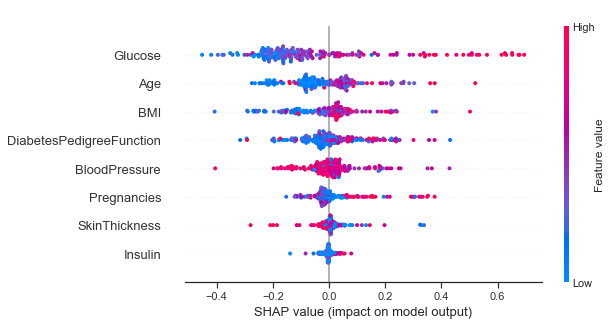

In [51]:
# Calculating shap_values for all of X_val rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_val,check_additivity=False)

# Creating summary plots
shap.summary_plot(shap_values[1],X_val)

We can also add the mean absolute value of the SHAP values for each feature to get a standard bar plot.

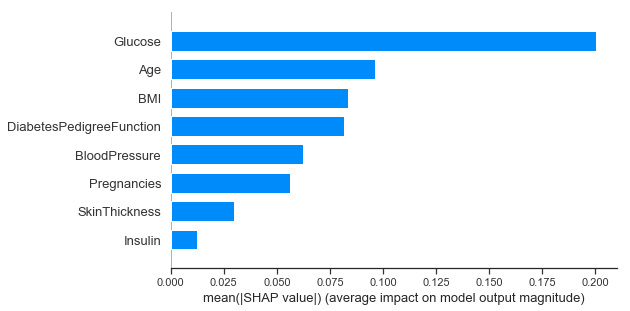

In [52]:
shap.summary_plot(shap_values[1], X_val, plot_type="bar")

### Interpretation

For every dot in the summary plot:

- Vertical location shows what feature is being depicted.
- Color shows whether that feature has a high or low value for that row of the dataset.
- Horizontal location shows whether the affect of that value has had a higher or lower affect on the prediction.

We get to know that a higher value of glucose level increases the risk of having diabetes and is one of the most important features. 

---

## 5. LIME: Locally Interpretable Model-Agnostic Explanations

LIME is a technique used to explain the predictions of any machine learning classifier and evaluate its usefulness in various tasks related to trust.
The framework of LIME was introduced in a paper titled: ["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938). LIME is capable of explaining the predictions of an ML model (classification/regression problem) in a reasonable way. 

LIME essentially approximates the predictions of the black box models locally with an interpretable model. This interpretable model could be a linear model with very few coefficients. I’m quoting the recipe for training a local interpretable model again from [Christop Molnar’s](https://twitter.com/ChristophMolnar) book [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/lime.html), since there cannot be a better way to summarize LIME’s working:

-   Select your instance of interest for which you want to have an explanation of its black box prediction.
-   Perturb your dataset and get the black box predictions for these new points.
-   Weight the new samples according to their proximity to the instance of interest.
-   Train a weighted, interpretable model on the dataset with the variations.
-   Explain the prediction by interpreting the local model.

### Usage

LIME is model agnostic, however, to make the explaination clear I shall be using it on a LightGbm model trained on the classic [Titanic Dataset](https://www.kaggle.com/c/titanic-dataset/data). The idea is to use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. You can read about the dataset [here](https://www.kaggle.com/c/titanic/data).

### Reading In and Preprocessing the Dataset

The datasets consist of missing values that need to be filled in. We shall also take care of the categorical variables.

In [53]:
# Reading in the data
df_titanic = pd.read_csv('data/titanic.csv')
df_titanic.drop('PassengerId',axis=1,inplace=True)

# Filling the missing values
df_titanic.fillna(0,inplace=True)

# label encoding categorical data
le = LabelEncoder()

df_titanic['Pclass_le'] = le.fit_transform(df_titanic['Pclass'])
df_titanic['SibSp_le'] = le.fit_transform(df_titanic['SibSp'])
df_titanic['Sex_le'] = le.fit_transform(df_titanic['Sex'])

cat_col = ['Pclass_le', 'Sex_le','SibSp_le', 'Parch','Fare']

# create validation set
X_train,X_val,y_train,y_val = train_test_split(df_titanic[cat_col],df_titanic[['Survived']],test_size=0.3)

### Training the LightGbm Model

In [54]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val)


# training the lightgbm model
lgb_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric':'binary_logloss',
    'metric': {'l2', 'auc'},
    'num_leaves': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': None,
    'num_iteration':100,
    'num_threads':7,
    'max_depth':12,
    'min_data_in_leaf':100,
    'alpha':0.5}
model = lgb.train(lgb_params,lgb_train,num_boost_round=10,valid_sets=lgb_eval,early_stopping_rounds=5)

# LIME requires class probabilities in case of classification example
def prob(data):
    return np.array(list(zip(1-model.predict(data),model.predict(data))))

[1]	valid_0's auc: 0.658605	valid_0's l2: 0.23171
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.791762	valid_0's l2: 0.21529
[3]	valid_0's auc: 0.766225	valid_0's l2: 0.212298
[4]	valid_0's auc: 0.756222	valid_0's l2: 0.210077
[5]	valid_0's auc: 0.7401	valid_0's l2: 0.208361
[6]	valid_0's auc: 0.768932	valid_0's l2: 0.196987
[7]	valid_0's auc: 0.793057	valid_0's l2: 0.187717
[8]	valid_0's auc: 0.782907	valid_0's l2: 0.186957
[9]	valid_0's auc: 0.800647	valid_0's l2: 0.180309
[10]	valid_0's auc: 0.813916	valid_0's l2: 0.174044
[11]	valid_0's auc: 0.813916	valid_0's l2: 0.174044
[12]	valid_0's auc: 0.813916	valid_0's l2: 0.174044
[13]	valid_0's auc: 0.813916	valid_0's l2: 0.174044
[14]	valid_0's auc: 0.813916	valid_0's l2: 0.174044
[15]	valid_0's auc: 0.813916	valid_0's l2: 0.174044
Early stopping, best iteration is:
[10]	valid_0's auc: 0.813916	valid_0's l2: 0.174044


### Usage

In [55]:
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = lime.lime_tabular.LimeTabularExplainer(df_titanic[model.feature_name()].astype(int).values,  
mode='classification',training_labels=df_titanic['Survived'],feature_names=model.feature_name())



Let's obtain the explanations from LIME for particular values in the validation dataset. Let's take the first observation:


In [56]:
i = 1
exp = explainer.explain_instance(df_titanic.loc[i,cat_col].astype(int).values, prob, num_features=5)

exp.show_in_notebook(show_table=True)

For the first prediciton, LIME provides an explanation for assigning it a particluar probability. The classifier predicts that this person's probability for surviving is 44%. The blue color indicates the reasons for the passenger's death (Survival = 0), orange indicates reasons for survival (Survival = 1). 

---

# Conclusion
Machine learning doesn’t have to be a black box anymore. What use is a good model if we cannot explain the results to others? Interpretability is as important as creating a model. To achieve wider acceptance among the population, it is crucial that machine learning systems are able to provide satisfactory explanations for their decisions. 
